# 1. Выбор набора данных

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('heart.csv', delimiter=',')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [2]:
X = dataset[['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']]
y = dataset['output']

# 2. Обучение случайного леса

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

n_estimators = 2
max_features = 0.5

model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)

model.fit(X, y)
pred = model.predict(X)
forest_accuracy = accuracy_score(y, pred)
forest_f1_score = f1_score(y, pred)

with open('f1_score.log', 'w') as file_:
  file_.write(f"Random forest F1-score: {forest_f1_score}\n")
  file_.write(f"Random forest accuracy: {forest_accuracy}\n\n\n")

# 3. Инициализация датафрейма с пустыми лейблами

многозначная логика

In [4]:
import pandas as pd

df = pd.DataFrame(index=X.index)
df['label_old'] = [[] for x in X.index]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label_old  303 non-null    object
dtypes: object(1)
memory usage: 2.5+ KB


# 4. Дизъюнкция для 4-значной логики

In [5]:
t = [1]
f = [0]
n = []
b = [0, 1]

In [6]:
def disj(labels):
  if labels[0] == labels[1]:
    return labels[0]
  elif labels[0] == t or labels[1] == t:
    return t
  elif labels[0] == f:
    return labels[1]
  elif labels[1] == f:
    return labels[0]
  else:
    return t

# 5. Создание случайного сэмпла


In [7]:
X_bt = X.sample(frac=max_features)
X_bt = X_bt.sample(frac=max_features, axis='columns')
y_bt = y.loc[X_bt.index]
X_bt.shape

(152, 6)

# 6. Обучение дерева решений

In [8]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_bt, y_bt)
pred = model.predict(X_bt)
accuracy_score(y_bt, pred)

1.0

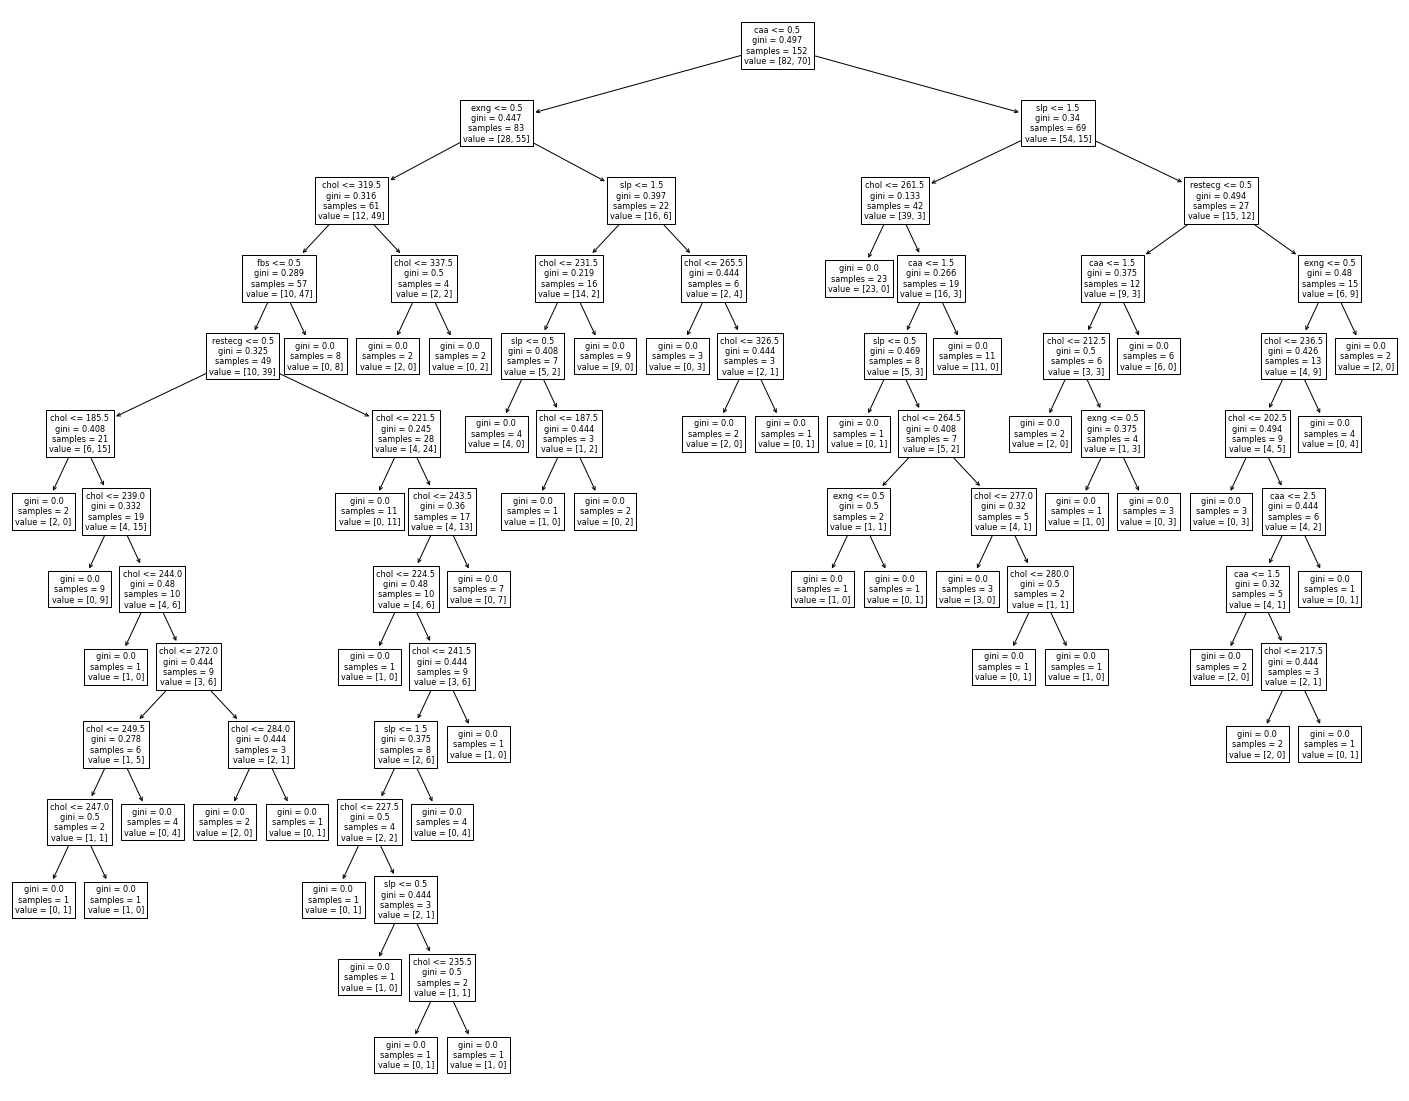

In [9]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25,20))
tree.plot_tree(model, 
               feature_names = X_bt.columns)
fig.show()

# 7. Переформатирование предсказанных лейблов согласно 4-значной логике


In [10]:
index_df = pd.DataFrame(index=X.index)
pred_df = pd.DataFrame(pred, index=X_bt.index, columns=['label_new'])
pred_df = pd.concat([index_df, pred_df], axis=1)
pred_df.head()

,label_new
0,NaN
1,1.0
2,NaN
3,NaN
4,1.0


In [11]:
pred_df['label_new'] = pred_df['label_new'].apply(lambda x: n if pd.isna(x) else [int(x)])
pred_df.head()

,label_new
0,[]
1,[1]
2,[]
3,[]
4,[1]


# 8. Соединение новых лейблов со старыми с помощью дизъюнкции

In [12]:
df = pd.concat([df, pred_df], axis=1)
df.head()

,label_old,label_new
0,[],[]
1,[],[1]
2,[],[]
3,[],[]
4,[],[1]


In [13]:
df['label_old'] = df[['label_old', 'label_new']].values.tolist()
df = df.drop(columns=['label_new'])
df.to_csv('labels.csv')
df.head()

,label_old
0,"[[], []]"
1,"[[], [1]]"
2,"[[], []]"
3,"[[], []]"
4,"[[], [1]]"


In [14]:
df['label_old'] = df['label_old'].apply(disj)
df.to_csv('labels.csv')
df.head()

,label_old
0,[]
1,[1]
2,[]
3,[]
4,[1]


# 9. Получение accuracy и F1-score

In [15]:
from sklearn.metrics import accuracy_score, f1_score

# заполняем пустые лейблы ложными значениями
pred = [x[0] if len(x) == 1 else -1 for x in df['label_old'].values]
pred = [pred[i] if pred[i]>-1 else (y[i]+1)%2 for i in range(len(pred))]

acc = accuracy_score(y, pred)
f1 = f1_score(y, pred)
print(f'Accuracy: {acc}')
print(f'F1-score: {f1}')

Accuracy: 0.23102310231023102
F1-score: 0.3753351206434317


In [16]:
from sklearn.metrics import precision_score

pred = [x if x==1 else 0 for x in pred]
precision_score(y, pred)

0.33653846153846156

# 10. Максимизация F1-score за счет повторения обучения дерева

In [17]:
iteration = 0

iter_f1_scores = [f1]

In [24]:
iteration += 1

print(f'Iteration: {iteration}')

X_bt = X.sample(frac=max_features)
X_bt = X_bt.sample(frac=max_features, axis='columns')
y_bt = y.loc[X_bt.index]

model = DecisionTreeClassifier()
model.fit(X_bt, y_bt)
pred = model.predict(X_bt)

index_df = pd.DataFrame(index=X.index)
pred_df = pd.DataFrame(pred, index=X_bt.index, columns=['label_new'])
pred_df = pd.concat([index_df, pred_df], axis=1)

pred_df['label_new'] = pred_df['label_new'].apply(lambda x: n if pd.isna(x) else [int(x)])

df = pd.concat([df, pred_df], axis=1)

df['label_old'] = df[['label_old', 'label_new']].values.tolist()
df = df.drop(columns=['label_new'])

df['label_old'] = df['label_old'].apply(disj)
df.to_csv('labels.csv')

print('Labels:')
print(df.head())

# заполняем пустые лейблы ложными значениями
pred = [x[0] if len(x) == 1 else -1 for x in df['label_old'].values]
pred = [pred[i] if pred[i]>-1 else (y[i]+1)%2 for i in range(len(pred))]

acc = accuracy_score(y, pred)
f1 = f1_score(y, pred)
print(f'Accuracy: {acc}')
print(f'F1-score: {f1}')
print(f'F1-score increase: {f1-iter_f1_scores[-1]}')

with open('f1_score.log', 'a') as file_:
  file_.write(f"Iteration {iteration} - F1-score: {f1}\n")
  file_.write(f"Iteration {iteration} - accuracy: {acc}\n\n")

iter_f1_scores.append(f1)

Iteration: 7
Labels:
  label_old
0       [1]
1       [1]
2       [1]
3       [1]
4       [1]
Accuracy: 0.5412541254125413
F1-score: 0.702355460385439
F1-score increase: 0.0


# 11. Сравнение F1-score случайного леса и F1-score итерационно полученных лейблов

In [33]:
print(f'F1-score итерационный: {f1}')
print(f'F1-score случайный лес: {f1}')

F1-score итерационный: 0.7051282051282052
F1-score случайный лес: 0.7051282051282052
